In [2]:
import requests
import re
from bs4 import BeautifulSoup
from pathlib import Path

# Set base values
download_folder = Path.cwd() / 'download'
base_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/'


# Initiate Session and get the Index-Page
with requests.Session() as s:
    resp = s.get(base_url)

# Parse the Index-Page for all relevant <a href>
soup = BeautifulSoup(resp.content)
links = soup.findAll("a", href=re.compile("stundenwerte_TU_.*_hist.zip"))

# For testing, only download 10 files
file_max = 10
dl_count = 0

#Download the .zip files to the download_folder
for link in links:
    zip_response = requests.get(base_url + link['href'], stream=True)
    # Limit the downloads while testing
    dl_count += 1
    if dl_count > file_max:
        break
    with open(Path(download_folder) / link['href'], 'wb') as file:
        for chunk in zip_response.iter_content(chunk_size=128):
            file.write(chunk)

print('Done')

Done


In [3]:
from pathlib import Path
import glob
import re
from zipfile import ZipFile

# Folder definitions
download_folder = Path.cwd() / 'download'
import_folder = Path.cwd() / 'import'

# Find all .zip files and generate a list
unzip_files = glob.glob('download/stundenwerte_TU_*_hist.zip')

# Set the name pattern of the file we need
regex_name = re.compile('produkt.*')

# Open all files, look for files that match ne regex pattern, extract to 'import'
for file in unzip_files:
    with ZipFile(file, 'r') as zipObj:
        list_of_filenames = zipObj.namelist()
        extract_filename = list(filter(regex_name.match, list_of_filenames))[0]
        zipObj.extract(extract_filename, import_folder)

display('Done')

'Done'

In [8]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

from pathlib import Path
import glob


import_files = glob.glob('import/*')
out_file = Path.cwd() / "export_uncleaned" / "to_clean"

obsolete_columns = [
    'QN_9',
    'RF_TU',
    'eor'
]

main_df = pd.DataFrame()
i = 1

for file in import_files:

    # Read in the next file
    df = pd.read_csv(file, delimiter=";")

    # Prepare the df before merging (Drop obsolete, convert to datetime, filter to date, set index)
    df.drop(columns=obsolete_columns, inplace=True)
    df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H")
    df = df[df['MESS_DATUM']>= "2007-01-01"]
    df.set_index(['MESS_DATUM', 'STATIONS_ID'], inplace=True)

    # Merge to the main_df
    main_df = pd.concat([main_df, df])

    # Display some status messages
    clear_output(wait=True)
    display('Finished file: {}'.format(file), 'This is file {}'.format(i))
    display('Shape of the main_df is: {}'.format(main_df.shape))
    i+=1

# Check if all types are correct
display(main_df['TT_TU'].apply(lambda x: type(x).__name__).value_counts())

# Make sure that to files or observations a duplicates, eg. scan the index for duplicate entries.
# The ~ is a bitwise operation, meaning it flips all bits.
main_df = main_df[~main_df.index.duplicated(keep='last')]


# Unstack the main_df
main_df = main_df.unstack('STATIONS_ID')
display('Shape of the main_df is: {}'.format(main_df.shape))

# Save main_df to a .csv file and a pickle to continue working in the next step
main_df.to_pickle(Path(out_file).with_suffix('.pkl'))
main_df.to_csv(Path(out_file).with_suffix('.csv'), sep=";")


'Finished file: import/produkt_tu_stunde_19500401_20110331_00003.txt'

'This is file 10'

'Shape of the main_df is: (824909, 1)'

float    824909
Name: TT_TU, dtype: int64

'Shape of the main_df is: (122736, 7)'

In [9]:
main_df.head()

TT_TU                            
STATIONS_ID            3   44  71  73    78    91  96
MESS_DATUM                                           
2007-01-01 00:00:00  11.4 NaN NaN NaN  11.0   9.4 NaN
2007-01-01 01:00:00  12.0 NaN NaN NaN  11.4   9.6 NaN
2007-01-01 02:00:00  12.3 NaN NaN NaN   9.4  10.0 NaN
2007-01-01 03:00:00  11.5 NaN NaN NaN   9.3   9.7 NaN
2007-01-01 04:00:00   9.6 NaN NaN NaN   8.6  10.2 NaN

In [7]:
main_df.describe()

TT_TU                 ...                            
STATIONS_ID            3              44  ...             91           96
count        37224.000000  119787.000000  ...  113950.000000  6399.000000
mean            10.103922       9.825787  ...       9.199869    12.730255
std              7.200001      19.363368  ...       8.400713    23.189555
min            -13.600000    -999.000000  ...    -999.000000  -999.000000
25%              5.000000       5.000000  ...       3.400000     7.250000
50%              9.900000      10.000000  ...       8.900000    13.200000
75%             15.300000      15.200000  ...      14.700000    18.500000
max             36.200000      37.000000  ...      36.900000    37.900000

[8 rows x 7 columns]

In [27]:
main_df['TT_TU'][3]

(122736,)

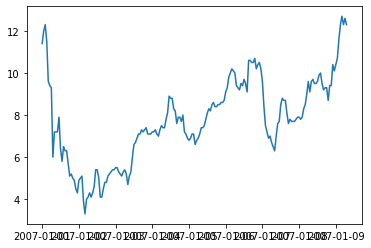

In [33]:
import matplotlib.pyplot as plt
plt.plot(main_df['TT_TU'][3][:200])